## Brief Summary

In this paper, I implemented a feed forward neural network using only numpy. Different activation functions have their own classes, where the forward and backward method implements the feedforward and backpropagation step. Similarly as an output of the final layer, we have separate class for Softmax operation. Another class is designed for maintaining the linear hidden layers. 

In the final model class, we can choose the type and structure of the hidden layers, activation functions between the hidden layers and the final output for the final layers. In addition we also need to provide the cost function which will be used to generate loss for backpropagation. 

I used MNIST dataset to classify the digit image. This is a classification problem, so we used softmax function at the final layer which will produce a probability for each of the output layer neuron. For primary investigation, we used a network of 2 hidden layers with 128 and 64 neurons. Just by changing the layers attribute of the model class, we can easily modify our network structures. We used Leaky ReLU as activation function as they do not suffer from the vanishing gradient (like sigmoid) or dead neuron (like ReLU) problem. Similarly to avoid vanishing gradient problem, we used He weight initialization. Multi-class cross entropy is used as the loss function. Our model is capable to use the L2 regularization and dropout. Similarly it is designed to incorporate SGD, Nesterov Momentum, RMSProp and Adam optimizer.

Backpropagation starts from the cost function, then it follows backward to the Softmax, hidden layers and activation function. So other than the cost function, every backward method takes the input of the gradient wrt the next layer and outputs the gradient wrt the previous layer.

In primary investigation with only SGD and a learning rate of 0.5, the model completed 10 epoch in 5 min with a validation loss of 0.13.  

### Export Data

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt


In [2]:
x_orig, y_orig = fetch_openml('mnist_784', version=1, return_X_y=True)


In [3]:
inputs = np.array((x_orig/255).astype('float32'))
y = np.array(y_orig, dtype = 'int')
targets = np.eye(10)[y]

### Activation Functions

In [42]:
class Sigmoid():
    def forward(self, x):
        self.sigmoid = 1. / (1 + np.exp(-x))
        return self.sigmoid

    def backward(self, gradient):
        return self.sigmoid * (1 - self.sigmoid) * gradient

class ReLU():
    def forward(self, x):
        self.x = x
        return (x>0)*1
    
    def backward(self, gradient):
        return (self.x > 0) * gradient

class LeakyReLU():
    def __init__(self, alpha = 0.01):
        self.alpha = alpha
        
    def forward(self, x):
        self.x = x
        return (x>0)*x + (x<0)*self.alpha*x
    
    def backward(self, gradient):
        return ( (self.x>0) + (self.x<0)*self.alpha ) * gradient

### Output Layer

In [5]:
class Softmax():
    def forward(self, x):
        exps = np.exp(x - x.max())
        self.output = exps / np.sum(exps, axis = 1)[:,None]
        return self.output

    def backward(self, gradient):
        return self.output * (gradient - 
                              (gradient * self.output).sum(axis=1)[:,None] )


### Loss Function

In [6]:
class CrossEntropy():
    def forward(self, y_pred, y_true):
        self.y_pred = y_pred
        self.y_true = y_true
        return np.sum(-1. * y_true * np.log(y_pred)) / y_pred.shape[0]

    def backward(self):
        return -1. * self.y_true / self.y_pred

### Linear Layers

In [21]:
(np.random.rand(5) < 0.5) * np.array([1,2,3,4,5])

array([1, 2, 0, 4, 0])

In [23]:
class Linear():
    def __init__(self, n_input, n_output, dropout_p = 0):
        # He weight initialization as default activation is ReLU
        self.Ws = np.random.randn(n_input, n_output) * np.sqrt(2/n_input)
        self.bs = np.zeros(n_output)
        # parameters for momentum optimizer
        self.vw = np.zeros((n_input, n_output))
        self.vb = np.zeros(n_output)
        # parameters for RMSprop optimizer
        self.grad_sq_w = np.zeros((n_input, n_output))
        self.grad_sq_b = np.zeros(n_output)
        # parameters for adam optimizer
        self.moment_1_w = np.zeros((n_input, n_output))
        self.moment_2_w = np.zeros((n_input, n_output))
        self.moment_1_b = np.zeros(n_output)
        self.moment_2_b = np.zeros(n_output)
        self.dropout_p = dropout_p # dropout probability
    
    def forward(self, x):
        self.x = x
        # dropout layer: 0 means it will be dropped away
        dropout_layer = np.random.rand(len(self.bs)) > self.dropout_p
        return (np.dot(x, self.Ws) + self.bs) * dropout_layer

    def backward(self, gradient):
        self.grad_b = gradient.mean(axis=0)
        self.grad_W = (self.x[:,:,None] @ gradient[:,None,:]).mean(axis=0)
        return np.dot(gradient, self.Ws.transpose())

### Full Model

In [24]:
class Model():
    def __init__(self, layers, cost_func, n_epoch=10, lr=0.01, 
                 reg_lambda=0, beta = 0, decay_rate = 0,
                 beta1 = 0, beta2 = 0, dropout_p = 0):
        self.layers = layers
        self.cost = cost_func
        self.n_epoch = n_epoch
        self.lr = lr # learning rate
        self.beta = beta # momentum parameter
        self.reg_lambda = reg_lambda # regularization parameter
        self.decay_rate = decay_rate # rmsprop decay parameter
        # Adam moment parameter
        self.beta1 = beta1
        self.beta2 = beta2
        self.dropout_p = dropout_p # dropout probability

    def forward(self, x):
        for layer in self.layers:
            if type(layer) == Linear:
                layer.dropout_p = self.dropout_p
            x = layer.forward(x)
        return x

    def loss(self, input, y_true):
        y_pred = self.forward(input)
        return self.cost.forward(y_pred, y_true)

    def backward(self):
        gradient = self.cost.backward()
        n_layer = len(self.layers)
        for i in range(n_layer-1, -1, -1):
            gradient = self.layers[i].backward(gradient)

    def make_minibatch(self, x_data, y_data, mb_size):
        minibatch_data = [(x_data[i:i+mb_size], y_data[i:i+mb_size]) \
                for i in range(0, len(x_data), mb_size)]
        return minibatch_data

    def train(self, features, targets, mb_size, test_size = 0.20,
              optimizer = 'nesterov'):
        x_train, x_val, y_train, y_val = train_test_split(features, targets, test_size=test_size, 
                                                          random_state=42)
        minibatch_data = self.make_minibatch(x_train, y_train, mb_size)
        self.train_loss = []
        self.test_loss = []
        for epoch in range(self.n_epoch):
            current_loss = 0
            n_batch = len(minibatch_data)
            for minibatch in minibatch_data:
                inputs, labels = minibatch
                current_loss += self.loss(inputs, labels)
                self.backward()
                # paramter updates
                for layer in self.layers:
                    if type(layer) == Linear:
                        if optimizer == 'nesterov':
                            self.nesterov_momentum(layer)
                        elif optimizer == 'rmsprop':
                            self.rmsprop(layer)
                        elif optimizer == 'adam':
                            self.adam(layer, epoch)
            self.train_loss.append(current_loss/n_batch)
            self.test_loss.append(self.loss(x_val, y_val))
            if (epoch+1) % 5 == 0:
                print(f'Epoch {epoch+1}/{self.n_epoch}: loss = {self.train_loss[epoch]}')

    def loss_curve(self):
        plt.plot(range(1, self.n_epoch+1), self.train_loss, label = 'train')
        plt.plot(range(1, self.n_epoch+1), self.test_loss, label = 'test')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Cross Entropy Loss')
        plt.title('Loss Curve')

    def nesterov_momentum(self, layer):
        '''
        for beta = 0, it becomes a normal SGD
        for reg_alpha = 0, there will be no regularization
        '''
        vw_old = layer.vw
        # velocity update with regularization (weight decay)
        layer.vw = self.beta * vw_old - self.lr * layer.grad_W \
                    - self.lr * self.reg_lambda * layer.Ws
        # position Update
        layer.Ws += (1+self.beta) * layer.vw - self.beta * vw_old
        
        vb_old = layer.vb
        # velocity update 
        layer.vb = self.beta * vb_old - self.lr * layer.grad_b
        # position Update
        layer.bs += (1+self.beta) * layer.vb - self.beta * vb_old
                
    def rmsprop(self, layer):
        layer.grad_sq_w = self.decay_rate * layer.grad_sq_w \
                + (1 - self.decay_rate) * layer.grad_W**2
        layer.Ws += - self.lr * layer.grad_W / (np.sqrt(layer.grad_sq_w) + 1e-7)

        layer.grad_sq_b = self.decay_rate * layer.grad_sq_b \
                + (1 - self.decay_rate) * layer.grad_b**2
        layer.bs -= self.lr * layer.grad_b / (np.sqrt(layer.grad_sq_b) + 1e-7)

    def adam(self, layer, epoch):
        # moment update
        layer.moment_1_w = self.beta1 * layer.moment_1_w \
                + (1 - self.beta1) * layer.grad_W
        layer.moment_2_w = self.beta2 * layer.moment_2_w \
                + (1 - self.beta2) * layer.grad_W**2
        # bias correction
        unbias_moment_1_w = layer.moment_1_w / (1 - self.beta1 ** (epoch+1))
        unbias_moment_2_w = layer.moment_2_w / (1 - self.beta2 ** (epoch+1))
        # update parameter
        layer.Ws -= self.lr * unbias_moment_1_w / (np.sqrt(unbias_moment_2_w) + 1e-7)

        # moment update
        layer.moment_1_b = self.beta1 * layer.moment_1_b \
                + (1 - self.beta1) * layer.grad_b
        layer.moment_2_b = self.beta2 * layer.moment_2_b \
                + (1 - self.beta2) * layer.grad_b**2
        # bias correction
        unbias_moment_1_b = layer.moment_1_b / (1 - self.beta1 ** (epoch+1))
        unbias_moment_2_b = layer.moment_2_b / (1 - self.beta2 ** (epoch+1))
        # update parameter
        layer.bs -= self.lr * unbias_moment_1_b / (np.sqrt(unbias_moment_2_b) + 1e-7)    


## Testing Working Model

### SGD

In [43]:
model = Model([Linear(784,128), LeakyReLU(), Linear(128,64), LeakyReLU(), Linear(64,10), Softmax()], CrossEntropy())

model.n_epoch = 1
model.lr = 0.1
model.reg_lambda = 0

mb_size = 50
model.train(inputs, targets, mb_size, 
            optimizer='nesterov')

In [47]:
model.n_epoch = 1
model.test_loss[-1], model.train_loss[-1]

(0.18076048213141493, 0.3187320765505537)

In [51]:
# we will use test dataset for the unbiased evaluation of the final model 
x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.20, 
                                                          random_state=42)

In [59]:
# random search 1-fold cross_validation
n_iterations = 10
validation_loss  = []
lr_s = []
for _ in range(n_iterations):
    model = Model([Linear(784,128), LeakyReLU(), Linear(128,64), LeakyReLU(), 
                   Linear(64,10), Softmax()], CrossEntropy())
    model.lr = 10**np.random.uniform(-6,1)
    model.n_epoch = 2
    mb_size = 50
    model.train(x_train, y_train, mb_size, 
                optimizer='nesterov')
    validation_loss.append(model.test_loss[-1])
    lr_s.append(model.lr)


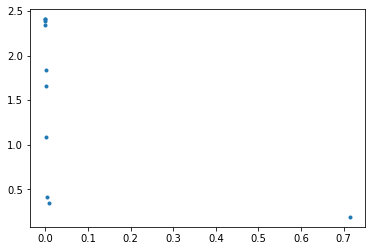

In [64]:
plt.plot(lr_s, validation_loss,'.')

Epoch 5/10: loss = 0.05425715980876315
Epoch 10/10: loss = 0.02961947304835689


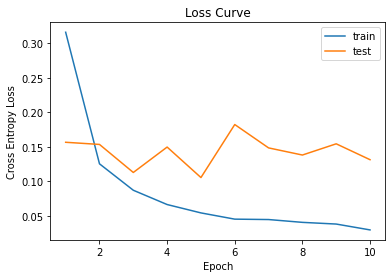

In [65]:
model = Model([Linear(784,128), LeakyReLU(), Linear(128,64), LeakyReLU(), 
                Linear(64,10), Softmax()], CrossEntropy())
model.lr = 0.5
model.n_epoch = 10
mb_size = 50
model.train(x_train, y_train, mb_size, 
            optimizer='nesterov')
model.loss_curve()

In [66]:
model.train_loss[-1], model.test_loss[-1]

(0.02961947304835689, 0.13130076481722563)

### SGD + Momentum

In [77]:
model = Model([Linear(784,128), ReLU(), Linear(128,64), ReLU(), Linear(64,10), Softmax()], CrossEntropy())

model.n_epoch = 50
model.lr = 0.2
model.reg_lambda = 0
model.beta = 0.9

mb_size = 50
model.train(inputs[:1000], targets[:1000], mb_size, 
            optimizer='nesterov')

Epoch 5/50: loss = 1.1517014898087208
Epoch 10/50: loss = 1.00662743040652
Epoch 15/50: loss = 0.9443916198321197
Epoch 20/50: loss = 1.0084874563668824
Epoch 25/50: loss = 0.9643326139300877
Epoch 30/50: loss = 1.0130861220831628
Epoch 35/50: loss = 1.0398071627464067
Epoch 40/50: loss = 0.980003936129946
Epoch 45/50: loss = 1.0596051365987094
Epoch 50/50: loss = 1.0330920507013976


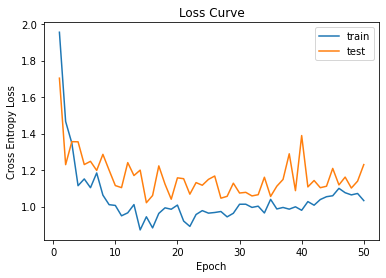

In [78]:
model.loss_curve()

### RMSprop

In [84]:
model = Model([Linear(784,128), ReLU(), Linear(128,64), ReLU(), Linear(64,10), Softmax()], CrossEntropy())

model.n_epoch = 50
model.lr = 0.1

model.decay_rate = 0.99
mb_size = 50
model.train(inputs[:1000], targets[:1000], mb_size, 
            optimizer='rmsprop')

Epoch 5/50: loss = 2.182079555828885
Epoch 10/50: loss = 2.1988231122133968
Epoch 15/50: loss = 2.1985008803422024
Epoch 20/50: loss = 2.194965930453911
Epoch 25/50: loss = 2.2040840284984777
Epoch 30/50: loss = 2.201275018452942
Epoch 35/50: loss = 2.1953194477842866
Epoch 40/50: loss = 2.1929040052329642
Epoch 45/50: loss = 2.186529289103248
Epoch 50/50: loss = 2.161922242154096


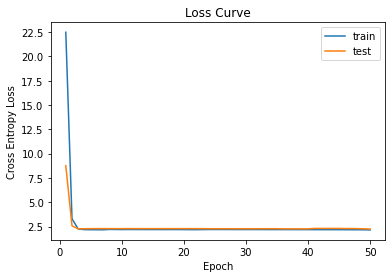

In [85]:
model.loss_curve()

### Adam

In [86]:
model = Model([Linear(784,128), ReLU(), Linear(128,64), ReLU(), Linear(64,10), Softmax()], CrossEntropy())

model.n_epoch = 50
model.lr = 0.1

model.beta1 = 0.9
model.beta2 = 0.999

mb_size = 50
model.train(inputs[:1000], targets[:1000], mb_size, 
            optimizer='adam')

Epoch 5/50: loss = 1.6021393644126982
Epoch 10/50: loss = 1.5985715699298186
Epoch 15/50: loss = 1.5624256906820824
Epoch 20/50: loss = 1.593509593272557
Epoch 25/50: loss = 1.5915735457146003
Epoch 30/50: loss = 1.608829267389039
Epoch 35/50: loss = 1.62321705817252
Epoch 40/50: loss = 1.6164474601976628
Epoch 45/50: loss = 1.6298084917409386
Epoch 50/50: loss = 1.5982098766245372


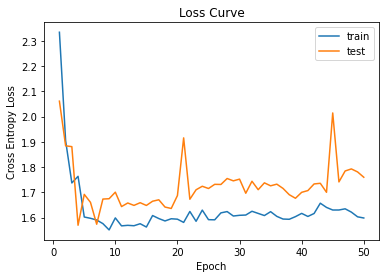

In [87]:
model.loss_curve()

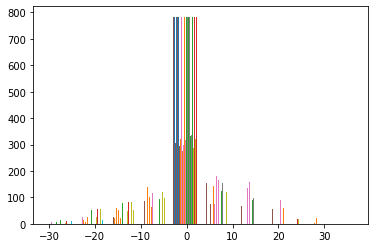

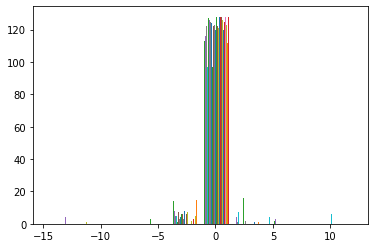

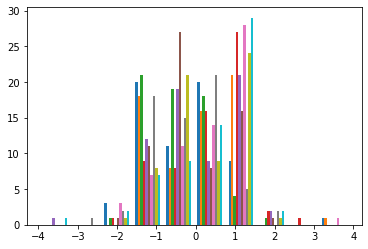

In [88]:
for layer in model.layers:
    if type(layer) == Linear:
        plt.hist(layer.Ws)
        plt.show()